## Requirement

In [1]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re
import math
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

from random import shuffle
from sklearn import model_selection as sk_model_selection

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.metrics import AUC

import tensorflow as tf

## Loading Data

In [2]:
data_directory = '../../data'
 
mri_types = ['FLAIR','T1w','T1wCE','T2w']
mri_types_id=0 # 0,1,2,3

IMAGE_SIZE = 256
NUM_IMAGES = 64
BATCH_SIZE= 4

num_folds=5
Selected_fold=1 #1,2,3,4,5 

train_df = pd.read_csv("../../data/train_labels.csv")
train_df['BraTS21ID5'] = [format(x, '05d') for x in train_df.BraTS21ID]
train_df["Fold"]="train"
train_df.head(5)

# For debug
#train_df=train_df.head(n=40)

,BraTS21ID,MGMT_value,BraTS21ID5,Fold
0,0,1,00000,train
1,2,1,00002,train
2,3,0,00003,train
3,5,1,00005,train
4,6,1,00006,train


In [3]:
sample_submission = pd.read_csv('../../data/sample_submission.csv')
test=sample_submission
test['BraTS21ID5'] = [format(x, '05d') for x in test.BraTS21ID]
test.head(3)

,BraTS21ID,MGMT_value,BraTS21ID5
0,1,0.5,00001
1,13,0.5,00013
2,15,0.5,00015


(1, 256, 256, 64)
0.0 1.0 0.07902179328632788 0.00023671822699371212
Dimension of the CT scan is: (256, 256, 64)


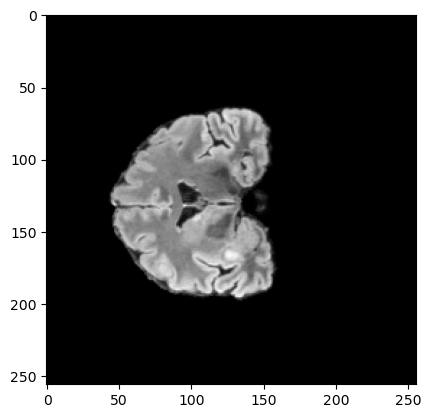

In [4]:
def load_dicom_image(path, img_size=IMAGE_SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data


def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=IMAGE_SIZE, mri_type=mri_types[mri_types_id], split="train", rotate=0):

    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)

a = load_dicom_images_3d("00000")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))
image = a[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 31]), cmap="gray")

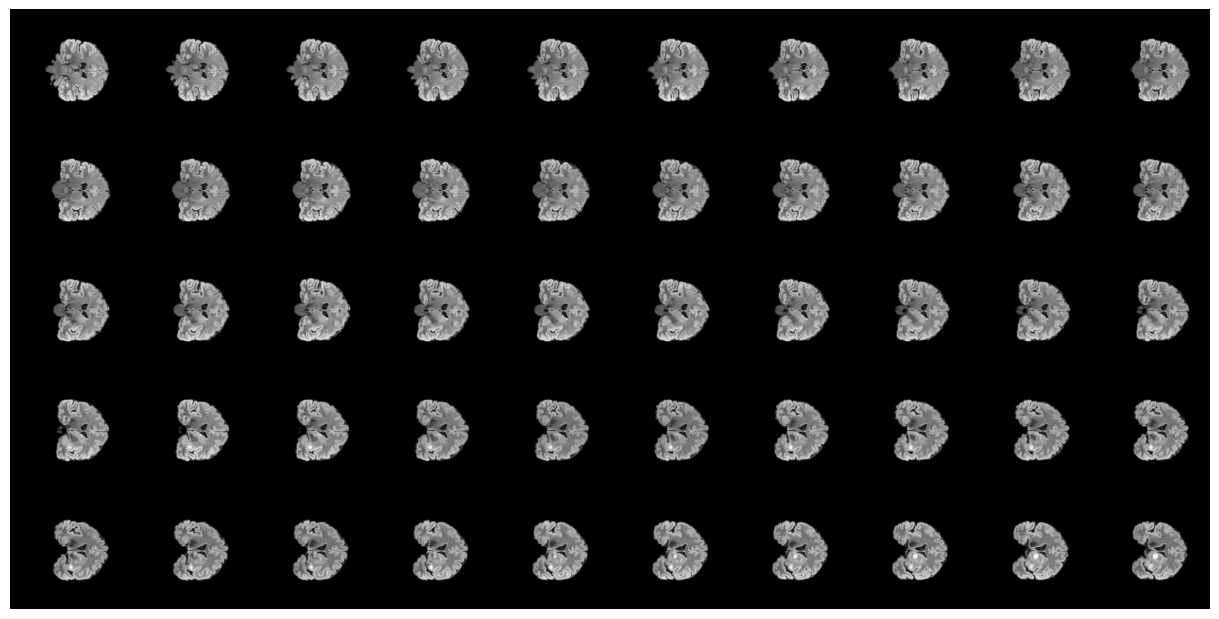

In [5]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))  
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()
# Visualize montage of slices.
# 5 rows and 10 columns for 100 slices of the CT scan.
plot_slices(5, 10, IMAGE_SIZE, IMAGE_SIZE, image[:, :, :50])

In [6]:
from sklearn.model_selection import KFold,StratifiedKFold
sfolder = StratifiedKFold(n_splits=5,random_state=13,shuffle=True)
X = train_df[['BraTS21ID']]
y = train_df[['MGMT_value']]

fold_no = 1
for train, valid in sfolder.split(X,y):
    if fold_no==Selected_fold:
        train_df.loc[valid, "Fold"] = "valid"
    fold_no += 1

In [7]:
df_train=train_df[train_df.Fold=="train"]
df_valid=train_df[train_df.Fold=="valid"]
print("df_train=",len(df_train),"-- df_valid=",len(df_valid))

df_train= 468 -- df_valid= 117


In [8]:
from keras.utils import Sequence
class Dataset(Sequence):
    def __init__(self,df,is_train=True,batch_size=BATCH_SIZE,shuffle=True):
        self.idx = df["BraTS21ID"].values
        self.paths = df["BraTS21ID5"].values
        self.y =  df["MGMT_value"].values
        self.is_train = is_train
        self.batch_size = batch_size
        self.shuffle = shuffle
    def __len__(self):
        return math.ceil(len(self.idx)/self.batch_size)
   
    def __getitem__(self,ids):
        id_path= self.paths[ids]
        batch_paths = self.paths[ids * self.batch_size:(ids + 1) * self.batch_size]
        
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
        
        if self.is_train:
            list_x =  [load_dicom_images_3d(x,split="train") for x in batch_paths]
            batch_X = np.stack(list_x, axis=4)
            return batch_X,batch_y
        else:
            list_x =  load_dicom_images_3d(id_path,split="test")#str(scan_id).zfill(5)
            batch_X = np.stack(list_x)
            return batch_X
    
    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            ids_y = list(zip(self.idx, self.y))
            shuffle(ids_y)
            self.idx, self.y = list(zip(*ids_y))

In [9]:
train_dataset = Dataset(df_train,batch_size=BATCH_SIZE)
valid_dataset = Dataset(df_valid,batch_size=BATCH_SIZE)

Dimension of the CT scan is: (1, 256, 256, 64, 4)
label= [1 1 0 1]


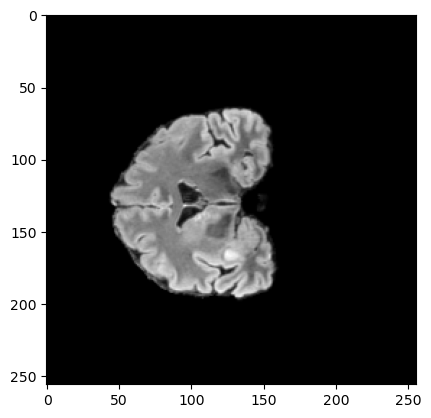

In [10]:
for i in range(1):
    images, label = train_dataset[i]
    print("Dimension of the CT scan is:", images.shape)
    print("label=",label)
    plt.imshow(images[0,:,:,32,0], cmap="gray")
    plt.show()

In [11]:
def get_model(width=IMAGE_SIZE, height=IMAGE_SIZE, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))
     
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.01)(x)
    
    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.02)(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.03)(x)

    x = layers.Conv3D(filters=512, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.04)(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=1024, activation="relu")(x)
    x = layers.Dropout(0.08)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")

    return model

# Build model.
model = get_model(width=IMAGE_SIZE, height=IMAGE_SIZE, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_2 (Conv3D)           (None, 254, 254, 62, 64)  1792      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 127, 127, 31, 64)  0        
 3D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 127, 127, 31, 64)  256      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 127, 127, 31, 64)  0         
                                                             

In [12]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[AUC(name='auc'),"acc"],
)
# Define callbacks.
model_save = ModelCheckpoint(f'Brain_3d_cls_{mri_types[mri_types_id]}_Fold_{Selected_fold}.h5', 
                             save_best_only = True, 
                             monitor = 'val_auc', 
                             mode = 'max', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_auc', 
                           patience = 10, mode = 'max', verbose = 1,
                           restore_best_weights = True)

# Train the model, doing validation at the end of each epoch
epochs = 50
model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks = [model_save, early_stop],
)

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node '3dcnn/conv3d_2/Conv3D' defined at (most recent call last):
    File "c:\Users\PC\miniconda3\envs\jtk\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\PC\miniconda3\envs\jtk\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\PC\miniconda3\envs\jtk\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\PC\miniconda3\envs\jtk\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\PC\miniconda3\envs\jtk\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\PC\AppData\Local\Temp\ipykernel_20916\2000117233.py", line 22, in <cell line: 22>
      model.fit(
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\layers\convolutional\base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "c:\Users\PC\miniconda3\envs\jtk\lib\site-packages\keras\layers\convolutional\base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: '3dcnn/conv3d_2/Conv3D'
Number of channels in filter (1) must match last dimension of input (4)
	 [[{{node 3dcnn/conv3d_2/Conv3D}}]] [Op:__inference_train_function_2153]

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax = ax.ravel()

for i, metric in enumerate(["acc","auc","loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
test_dataset = Dataset(test,is_train=False,batch_size=1)


for i in range(1):
    image = test_dataset[i]
    print("Dimension of the CT scan is:", image.shape)
    plt.imshow(image[0,:,:, 32], cmap="gray")
    plt.show()

In [ ]:
preds = model.predict(test_dataset)
preds = preds.reshape(-1)
preds

In [ ]:
submission = pd.DataFrame({'BraTS21ID':sample_submission['BraTS21ID'],'MGMT_value':preds})
submission

In [13]:
submission.to_csv('submission.csv',index=False)

NameError: name 'submission' is not defined

In [14]:
plt.figure(figsize=(5, 5))
plt.hist(submission["MGMT_value"]);

NameError: name 'submission' is not defined

<Figure size 500x500 with 0 Axes>